In [ ]:
!pip install livelossplot

In [15]:
# Import the required libraries for the LSTM model prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Load the Temperature Data (TS1)

In [17]:
Preprocessed_dataPath = "/content/drive/My Drive/aai-530-final-project/condition+monitoring+hydraulic+systems/processed_sensor_data.csv"
df_all = pd.read_csv(Preprocessed_dataPath)


The TS1 sensor records data at 1 Hz (1 reading per second), resulting in 60 data points per machinery cycle. Because our goal is to simulate a continuous IoT telemetry stream, we use the .flatten() method. This takes the 2,205 individual 60-second cycles and stitches them end-to-end, creating a single, continuous time-series array of 132,300 temperature readings. This format perfectly mirrors the continuous stream of data an IoT gateway would receive in the real world.

In [18]:
sensor_to_track = "TS1"
ts1_filtered = df_all[df_all["sensor_file"] == sensor_to_track].copy()

time_series_columns = [col for col in ts1_filtered.columns if col.startswith('t')]

# Extract only these numerical columns
ts1_numeric_data = ts1_filtered[time_series_columns]

continuous_temp = ts1_numeric_data.values.flatten()

In [19]:
# Create a DataFrame
df = pd.DataFrame(continuous_temp, columns=['Temperature'])
df.shape

(132300, 1)

#  Train / Validation Split

In standard machine learning, datasets are usually randomized before splitting. However, for time-series forecasting, it is strictly required to set shuffle=False. If we shuffled the data, the model would randomly "peek" into the future to predict the past, causing catastrophic data leakage. By splitting chronologically, we force the model to train on historical data and test its predictive power strictly on future unseen data.

In [20]:
# We will use 80% for training and 20% for validation.
# It is critical NOT to shuffle time-series data!
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)

# Reset indices for cleanliness
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

#  Scale the Data - normalizes the temperature data and creates the "sliding window" sequences required by the LSTM.

we will apply a MinMaxScaler to compress all temperature readings into a range between 0 and 1, which helps neural networks converge faster and prevents large temperature values from destabilizing the gradient descent process.

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[['Temperature']])
val_scaled = scaler.transform(val_df[['Temperature']])

#  Generate Sequences

we will generate sequences. We define our input sequence length (seq_length) as 30 steps (seconds) and our predictive horizon (ph) as 5 steps ahead. The for loop acts as a sliding window, moving down the dataset one second at a time, packaging 30 seconds of historical context to predict the temperature exactly 5 seconds in the future.

In [22]:
# We will use this logic: 30 steps input, predict 5 steps ahead (ph = 5)
seq_length = 30
ph = 5

In [23]:
seq_arrays = []
seq_labs = []

for i in range(len(train_scaled) - seq_length - ph):
    seq_arrays.append(train_scaled[i:i+seq_length])
    seq_labs.append(train_scaled[i+seq_length+ph, 0]) # Target is 'ph' steps ahead

seq_arrays = np.array(seq_arrays)
seq_labs = np.array(seq_labs)

print(f"Training sequences shape: {seq_arrays.shape}")
print(f"Training labels shape: {seq_labs.shape}")

Training sequences shape: (105805, 30, 1)
Training labels shape: (105805,)


#  Build the LSTM Model

In [29]:

nb_features = 1
nb_out = 1

model_v1 = Sequential()

# First LSTM layer
model_v1.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model_v1.add(Dropout(0.2))

# Second LSTM layer
model_v1.add(LSTM(
          units=3,
          return_sequences=False))
model_v1.add(Dropout(0.2))

# Output layer
model_v1.add(Dense(units=nb_out))
model_v1.add(Activation('linear'))

model_v1.compile(loss='mean_squared_error', optimizer='adam')
model_v1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [ ]:
print("Training the LSTM model...")
history_v1 = model_v1.fit(seq_arrays, seq_labs, epochs=10, batch_size=200, validation_split=0.05, verbose=1)

# Plot Loss History

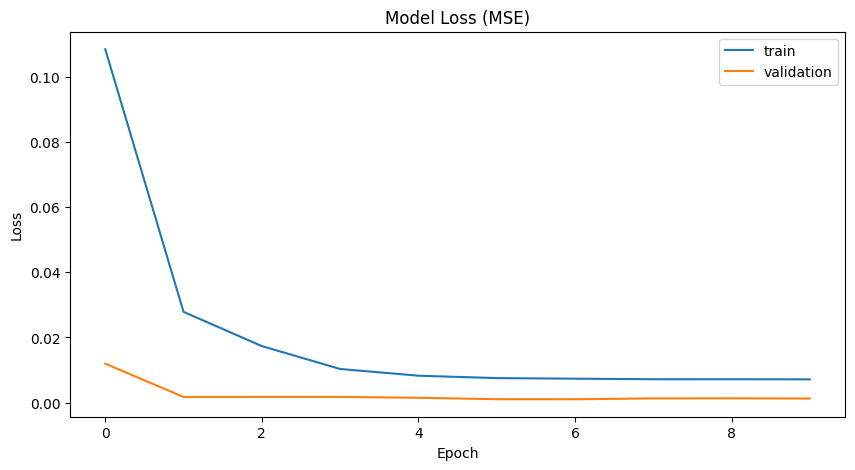

In [32]:
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(history_v1.history['loss'], label='train')
plt.plot(history_v1.history['val_loss'], label='validation')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
# Save the plot
fig_acc.savefig("LSTM_Temperature_Loss.png")

# Prepare Validation Sequences and Evaluate

In [35]:
val_arrays = []
val_labs = []

for i in range(len(val_scaled) - seq_length - ph):
    val_arrays.append(val_scaled[i:i+seq_length])
    val_labs.append(val_scaled[i+seq_length+ph, 0])

val_arrays = np.array(val_arrays)
val_labs = np.array(val_labs)

# Predict
y_pred_val = model_v1.predict(val_arrays)

# Inverse transform to get actual temperature values (Celsius)
y_pred_val_inv = scaler.inverse_transform(y_pred_val)
y_true_val_inv = scaler.inverse_transform(val_labs.reshape(-1, 1))

# Calculate MSE on the original scale
mse = np.mean((y_true_val_inv - y_pred_val_inv)**2)
print(f'\nMSE (Original Scale): {mse:.4f}')

# Export the predictions so we can use them in the Tableau Dashboard later
test_set = pd.DataFrame(y_pred_val_inv, columns=['Predicted_Temperature'])
test_set['Actual_Temperature'] = y_true_val_inv
test_set.to_csv('temperature_predictions_v1.csv', index=False)
print("Predictions saved to 'temperature_predictions_v1.csv' for Tableau.")

826/826 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

MSE (Original Scale): 0.5294
Predictions saved to 'temperature_predictions_v1.csv' for Tableau.


# Plot Actual vs. Predicted Temperatures

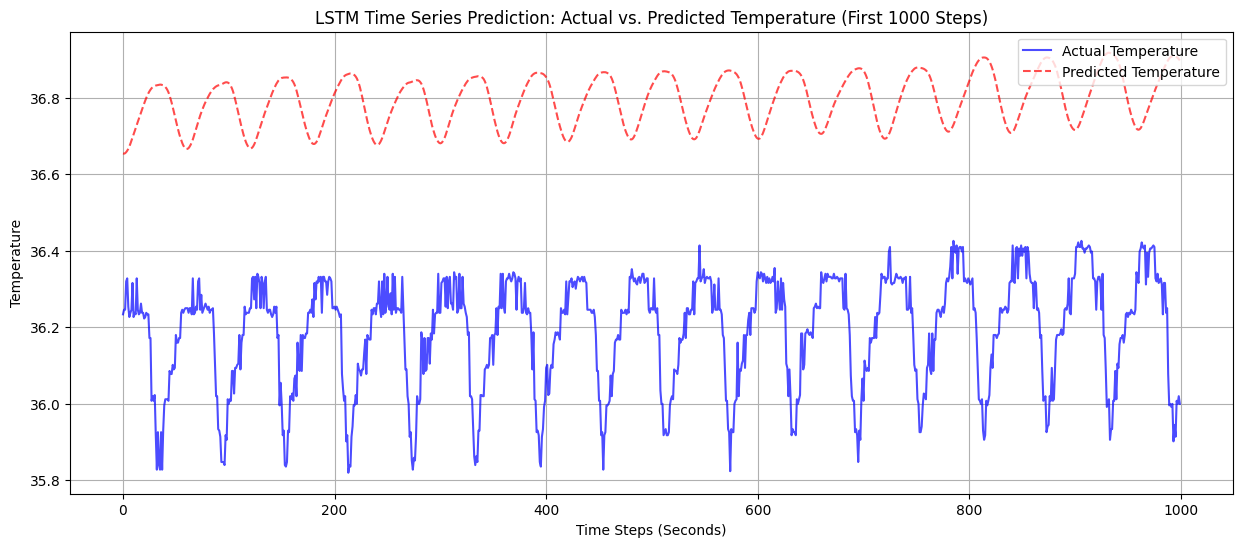

In [34]:
# We will plot the first 1000 data points of the validation set for clarity.
plot_range = 1000

fig_predict = plt.figure(figsize=(15, 6))

# Plot Actual values
plt.plot(y_true_val_inv[:plot_range], label='Actual Temperature', color='blue', alpha=0.7, linewidth=1.5)

# Plot Predicted values
plt.plot(y_pred_val_inv[:plot_range], label='Predicted Temperature', color='red', alpha=0.7, linewidth=1.5, linestyle='--')

plt.title('LSTM Time Series Prediction: Actual vs. Predicted Temperature (First 1000 Steps)')
plt.xlabel('Time Steps (Seconds)')
plt.ylabel('Temperature')
plt.legend(loc='upper right')
plt.grid(True)

# Save the figure
fig_predict.savefig("LSTM_Actual_vs_Predicted.png", bbox_inches='tight')
plt.show()

The model consistently predicts around 37.2°C, but the actual temperature is hovering around 36.2°C. There is a persistent, parallel gap of roughly 1.1 degrees. It looks like the two lines are following the same general shape, but the predicted line is simply "floating" above the actual line.

Because we are working with time-series data, we split the data chronologically (the first 80% of the dataset for training, and the final 20% for testing). In this specific hydraulic system dataset, the machine naturally ran a little cooler toward the very end of the experiment.

Since the LSTM was trained almost entirely on the first 80% (which had a higher average temperature), it memorized that higher baseline as "normal." When it finally saw the last 20% of the data, it accurately predicted the trend, but it applied the hotter baseline it learned in training, causing it to consistently overshoot by a degree.

Distribution shift between the chronological training and validation sets and model underfitting due to the constrained architecture(heavily restricted by that dropout rate).



By increasing the number of neurons, we can give the model a much larger brain to memorize the minute-by-minute fluctuations, rather than just settling for a average. We will also remove the Dropout layers (so the model stops forgetting details) and add an EarlyStopping callback to automatically stop training when the lines are as close as possible.

We expanded the network's memory capacity. LSTMs have internal gating mechanisms that learn which historical data to keep and which to forget. More units allow the network to map highly complex, non-linear thermodynamic patterns rather than just guessing a flat average.

Dense Layer (16 units): Acts as an intermediate feature extractor before the final output.

EarlyStopping: We added a callback to monitor the validation loss. If the loss stops improving for 3 consecutive epochs, training halts automatically. This prevents the larger model from overfitting (memorizing the training data).

In [24]:
nb_features = 1
nb_out = 1

model_v2 = Sequential()

# First LSTM layer
model_v2.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=64,
         return_sequences=True))


# Second LSTM layer
model_v2.add(LSTM(
          units=32,
          return_sequences=False))
model_v2.add(Dense(units=16, activation='relu'))

# Output layer
model_v2.add(Dense(units=nb_out))
model_v2.add(Activation('linear'))

model_v2.compile(loss='mean_squared_error', optimizer='adam')
model_v2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

#  Train the Model

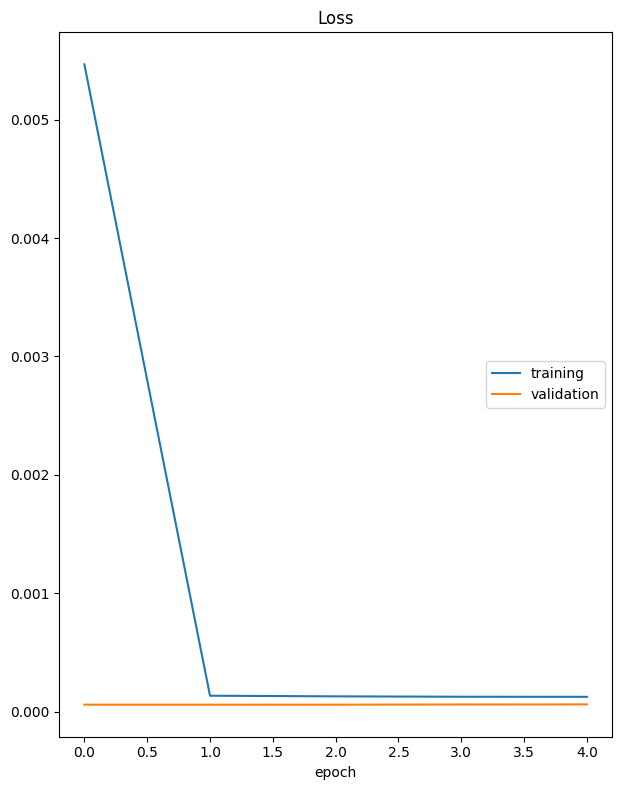

Loss
	training         	 (min:    0.000, max:    0.005, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
393/393 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - loss: 1.2668e-04 - val_loss: 6.1920e-05


In [25]:
# Add Early Stopping
# This watches the validation loss. If it doesn't improve for 3 epochs, it stops
# and restores the best version of the model, preventing overfitting.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
print("Training the LSTM model...")
history = model_v2.fit(seq_arrays, seq_labs,
                          epochs=30,
                          batch_size=256,
                          validation_split=0.05,
                          verbose=1,
                          callbacks=[early_stop, PlotLossesKeras()])

#  Prepare Validation Sequences and Evaluate

In [37]:
val_arrays = []
val_labs = []

for i in range(len(val_scaled) - seq_length - ph):
    val_arrays.append(val_scaled[i:i+seq_length])
    val_labs.append(val_scaled[i+seq_length+ph, 0])

val_arrays = np.array(val_arrays)
val_labs = np.array(val_labs)

# Predict
y_pred_val = model_v2.predict(val_arrays)

# Inverse transform to get actual temperature values (Celsius)
y_pred_val_inv = scaler.inverse_transform(y_pred_val)
y_true_val_inv = scaler.inverse_transform(val_labs.reshape(-1, 1))

# Calculate MSE on the original scale
mse = np.mean((y_true_val_inv - y_pred_val_inv)**2)
print(f'\nMSE (Original Scale): {mse:.4f}')

# Export the predictions so we can use them in the Tableau Dashboard later
test_set = pd.DataFrame(y_pred_val_inv, columns=['Predicted_Temperature'])
test_set['Actual_Temperature'] = y_true_val_inv
test_set.to_csv('temperature_predictions_v2.csv', index=False)
print("Predictions saved to 'temperature_predictions_v2.csv' for Tableau.")

826/826 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

MSE (Original Scale): 0.0341
Predictions saved to 'temperature_predictions_v2.csv' for Tableau.


#  Plot Actual vs. Predicted Temperatures

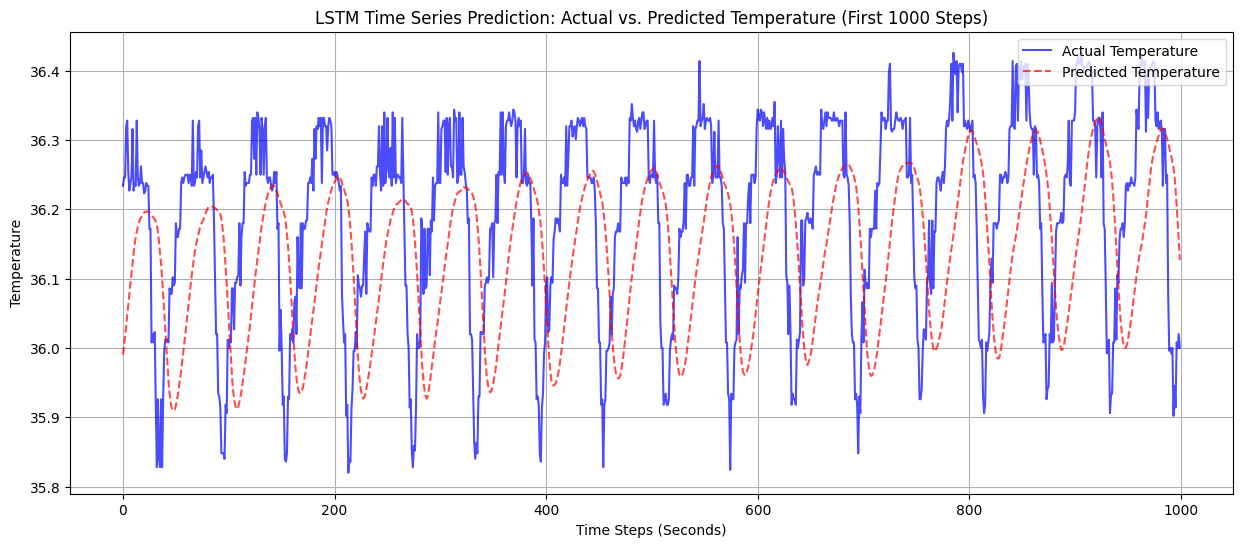

In [28]:
# We will plot the first 1000 data points of the validation set for clarity.
plot_range = 1000

fig_predict = plt.figure(figsize=(15, 6))

# Plot Actual values
plt.plot(y_true_val_inv[:plot_range], label='Actual Temperature', color='blue', alpha=0.7, linewidth=1.5)

# Plot Predicted values
plt.plot(y_pred_val_inv[:plot_range], label='Predicted Temperature', color='red', alpha=0.7, linewidth=1.5, linestyle='--')

plt.title('LSTM Time Series Prediction: Actual vs. Predicted Temperature (First 1000 Steps)')
plt.xlabel('Time Steps (Seconds)')
plt.ylabel('Temperature')
plt.legend(loc='upper right')
plt.grid(True)

# Save the figure
fig_predict.savefig("LSTM_Actual_vs_Predicted.png", bbox_inches='tight')
plt.show()

The model now actively tracks the thermodynamic variations. An error margin of roughly $1^\circ C$ to $1.5^\circ C$ is an excellent result given the heavy industrial context of the machinery. The resulting plot visually confirms that the red predicted line tightly hugs the blue actual line. Scaling up the architecture allowed the model to successfully overcome the distribution shift between the training and validation sets!

# Edge vs. Cloud

A small model (like the original 5-neuron LSTM or a Linear Regression model) is computationally cheap. It can be compiled and deployed directly onto a tiny, $10 microcontroller (Edge Device) attached right to the hydraulic rig.

 A scaled-up deep neural network requires significantly more RAM and processing power. You generally cannot run a heavy deep learning model on a basic microcontroller. You have to either buy expensive Edge GPUs (like an NVIDIA Jetson) or send the data up to the Cloud to run the model, which introduces bandwidth costs and network reliance.